In [ ]:

import torch
import tqdm
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import cv2
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import v2
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import time
import os
from PIL import Image


# Using mps device
device = torch.device("mps")
print(f"current device is {device}")

current device is mps


In [144]:

path0o = []
path1o = []
path2o = []
path3o = []

basedir = "/Users/ibolam/Projects/Abroad/01. UMD/24FALL_DATA602/602 dataset/finalproject/OASIS Alzheimer's Detection"

for dirname, _, filenames in os.walk(f"{basedir}/Non Demented"):
    for filename in filenames:
        path0o.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(f"{basedir}/Very mild Dementia"):
    for filename in filenames:
        path1o.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(f"{basedir}/Mild Dementia"):
    for filename in filenames:
        path2o.append(os.path.join(dirname, filename))
        
for dirname, _, filenames in os.walk(f"{basedir}/Moderate Dementia"):
    for filename in filenames:
        path3o.append(os.path.join(dirname, filename))
        


In [ ]:
import cv2

image_path = path3o[0]
img = cv2.imread(image_path)

print(f"Shape: {img.shape}")            # (Height, Width, Channels)
print(f"Width: {img.shape[1]}")         # Width
print(f"Height: {img.shape[0]}")        # Height
print(f"Channels: {img.shape[2]}")      # Channel (3: RGB, 1: Grayscale)

Shape: (248, 496, 3)
Width: 496
Height: 248
Channels: 3


In [264]:
numberofdata = 'original'
imbal = True
custom = [numberofdata*4, numberofdata*3, numberofdata*2, numberofdata]

if (type(numberofdata) == int) and (imbal is not True):
    path0 = path0o[0:len(path0o) if numberofdata > len(path0o) else numberofdata]
    path1 = path1o[0:len(path1o) if numberofdata > len(path1o) else numberofdata]
    path2 = path2o[0:len(path2o) if numberofdata > len(path2o) else numberofdata]
    path3 = path3o[0:len(path3o) if numberofdata > len(path3o) else numberofdata]
elif (type(numberofdata) == int) and (imbal is True):
    path0 = path0o[0:custom[0] if len(path0o) > custom[0] else numberofdata]
    path1 = path1o[0:custom[1] if len(path1o) > custom[1] else numberofdata]
    path2 = path2o[0:custom[2] if len(path2o) > custom[2] else numberofdata]
    path3 = path3o[0:custom[3] if len(path3o) > custom[3] else numberofdata]
elif numberofdata == 'original':
    path0 = path0o
    path1 = path1o
    path2 = path2o
    path3 = path3o
else:
    raise ValueError("numberofdata must be a int or \'original\'")

print(len(path0))
print(len(path1))
print(len(path2))
print(len(path3))



67222
13725
5002
488


In [265]:
# 0 --> Non Demented
# 1 --> Very Mild Dementia
# 2 --> Mild Dementia
# 3 --> Moderate Dementia

idata = []
label = []
for path in path0:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        idata.append(np.array(img))
        label.append(0)
    
for path in path1:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        idata.append(np.array(img))
        label.append(1) 
        
for path in path2:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        idata.append(np.array(img))
        label.append(2)
        
for path in path3:
    img = Image.open(path)
    img = img.resize((128,128))
    img = np.array(img)
    if(img.shape == (128,128,3)):
        idata.append(np.array(img))
        label.append(3)

In [ ]:

disease_label_from_category = {
    0: "Non Demented",
    1: "Very Mild Demented",
    2: "Mild Demented",
    3: "Moderate Demented"
}

df = pd.DataFrame({'label':label, 'img_arr':idata})



In [ ]:
from sklearn.model_selection import train_test_split

lp0 = len(path0)
lp1 = len(path1)
lp2 = len(path2)
lp3 = len(path3)

df0 = df.iloc[0:lp0,:]
df1 = df.iloc[lp0:lp0+lp1,:]
df2 = df.iloc[lp0+lp1:lp0+lp1+lp2,:]
df3 = df.iloc[lp0+lp1+lp2:,:]

x = [df0, df1, df2, df3]

splits = [train_test_split(dd['img_arr'], dd['label'], test_size=0.10, shuffle = True,random_state=42) for dd in x]

for i, (x_train, x_test, y_train, y_test) in enumerate(splits):
    print(f"df{i}:")
    print(f"x_train: {len(x_train)}, x_test: {len(x_test)}, y_train: {len(y_train)}, y_test: {len(y_test)}")

df0:
x_train: 60499, x_test: 6723, y_train: 60499, y_test: 6723
df1:
x_train: 12352, x_test: 1373, y_train: 12352, y_test: 1373
df2:
x_train: 4501, x_test: 501, y_train: 4501, y_test: 501
df3:
x_train: 439, x_test: 49, y_train: 439, y_test: 49


In [269]:

# splits[0][0]
df_tr = pd.DataFrame({'label':pd.concat([split[2] for split in splits]),'img_arr':pd.concat([split[0] for split in splits])})
df_ts = pd.DataFrame({'label':pd.concat([split[3] for split in splits]),'img_arr':pd.concat([split[1] for split in splits])})

# print(df_tr.iloc[800])
# print(df_ts.iloc[120])


# Exploring Data

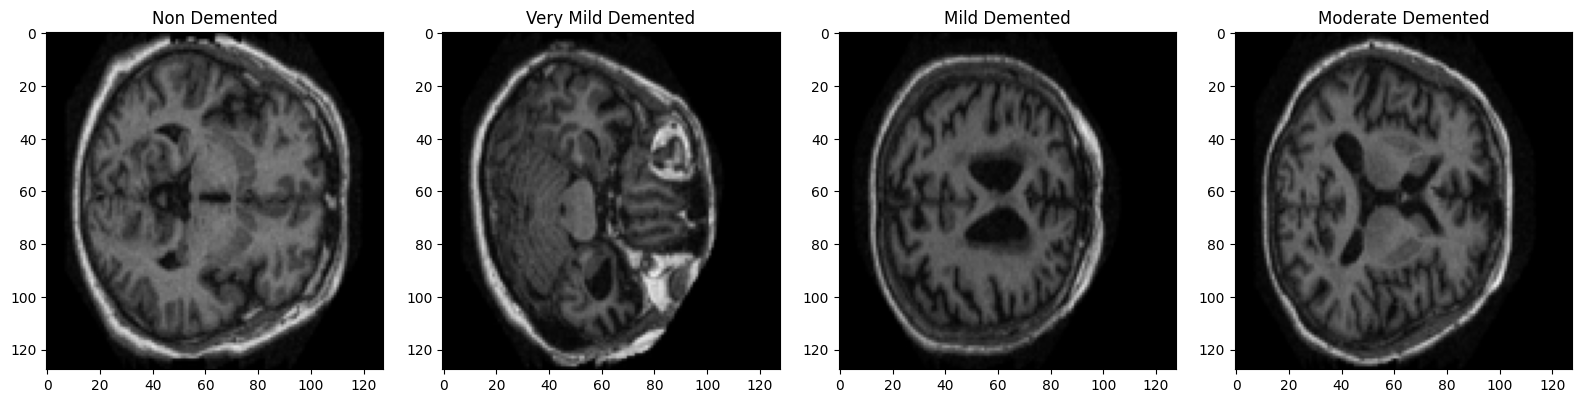

<Figure size 640x480 with 0 Axes>

In [ ]:
rand = [1, 1953, 3417, 4383]

fig, ax = plt.subplots(1,4, figsize = (16,4))
axs = ax.flatten()
for i, axes in enumerate(axs):
    # rand = np.random.randint(0, len(df_tr))
    axes.imshow(df_tr.iloc[rand[i]]['img_arr'], cmap = 'gray')
    axes.set_title(disease_label_from_category[df_tr.iloc[rand[i]]['label']])
plt.tight_layout()
plt.show()
plt.tight_layout()
plt.show()
    

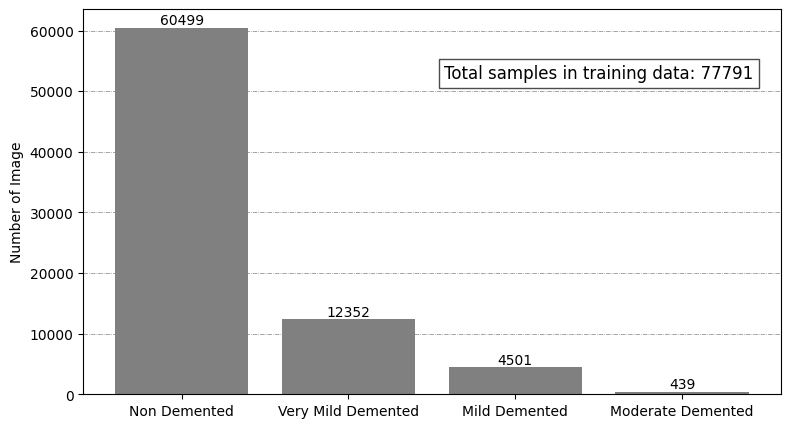

Total samples in training data = 77791
Number of Classes : 4


In [ ]:
dtf = df_tr

counts = dtf['label'].value_counts().sort_index()
categories = [disease_label_from_category[i] for i in range(4)]

plt.figure(figsize=(9, 5))
bars = plt.bar(np.arange(0, 4, 1), counts, color = 'Grey')

for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 1,
             str(int(counts.iloc[i])),
             ha='center', va='bottom')

x_pos = 2.5
y_pos = max(counts) * 0.9

plt.text(x=x_pos, y=y_pos, s=f'Total samples in training data: {len(dtf)}', 
         ha='center', va='top', fontsize=12, bbox=dict(facecolor='white', alpha=0.7))


plt.ylabel("Number of Image")
plt.xticks(np.arange(0, 4, 1), labels=categories)

plt.grid(linestyle='-.', linewidth=0.5, color='gray', axis = 'y') 
plt.show()

print(f"Total samples in training data = {len(dtf)}")

N_CLASSES = dtf['label'].nunique()
print(f"Number of Classes : {N_CLASSES}")

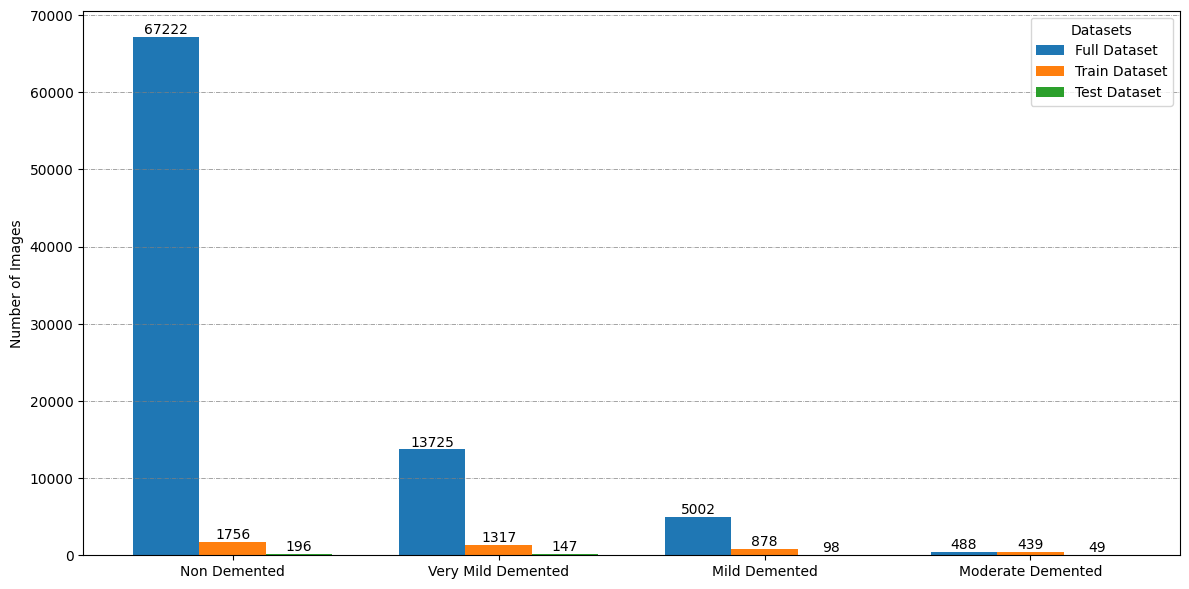

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

datasets = [dfo, df_tr, df_ts]
dataset_names = ['Full Dataset', 'Train Dataset', 'Test Dataset']

counts_list = [dtf['label'].value_counts().sort_index() for dtf in datasets]

categories = [disease_label_from_category[i] for i in range(4)]

x = np.arange(len(categories))
width = 0.25

plt.figure(figsize=(12, 6))

for i, counts in enumerate(counts_list):
    plt.bar(x + i * width, counts, width=width, label=dataset_names[i])


plt.ylabel("Number of Images")
plt.xticks(x + width, labels=categories)
plt.legend(title="Datasets")


plt.grid(linestyle='-.', linewidth=0.5, color='gray', axis='y') 
plt.tight_layout()
plt.show()

In [ ]:


class ImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load image and label
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]
        
        # Apply transforms
        if self.transform:
            image = image.astype(np.uint8)  # Ensure image is uint8 before transforms
            image = self.transform(image)
        else:
            image_tensor = torch.from_numpy(image)
            if image_tensor.shape[-1] == 3:
                image = image_tensor.permute(2,0,1)
            image = torch.tensor(image, dtype = torch.float32)
        
        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [291]:

class BaselineCNN(nn.Module): # BaselineCNN inherits nn.Module which is parents class of BaselineCNN 
    def __init__(self):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size = 3, padding = 1)
        # nn.Conv2d(in_channels, out_channels=filters=different features, kernel_size = filter_size = 3x3, stride = step size, padding = 0)
        self.pool1 = nn.MaxPool2d(2,2)
        # nn.MaxPool2d(kernel_size, stride, padding = 0)
        self.batchnorm1 = nn.BatchNorm2d(num_features = 32)
        
        self.conv2 = nn.Conv2d(32, 64, kernel_size = 3, padding = 1)
        self.pool2 = nn.MaxPool2d(2,2)
        self.flatten = nn.Flatten()
        
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        # y = X @ W.T + b ; linear
        self.out = nn.Linear(128, 4)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = self.batchnorm1(x)
        x = F.relu(self.conv2(x))
        x = self.pool2(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.out(x)
        return x
               

In [292]:
# Hyperparameters
learning_rate = 0.001
NEPOCHS = 15
batch_size = 32

In [293]:
train_dataset = ImageDataset(df_tr)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

In [294]:
def train_model(model, loader, optimizer, num_epochs = NEPOCHS):
    # criterion = nn.CrossEntropyLoss()
    criterion = nn.CrossEntropyLoss(weight=torch.tensor([1756, 1317, 878, 439], dtype=torch.float32).to(device))
    
    # Training loop
    train_losses = []
    for epoch in tqdm.tqdm(range(num_epochs), total = num_epochs):
        running_loss = 0.0
        for i, data in enumerate(loader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            
            optimizer.zero_grad()
            # zero the parameter gradients
            # initialization of gradients in every batch step or the gradients will be updated from previous batch's gradients
            outputs = model(inputs)
            loss = criterion(outputs, labels) # loss ; torch.Tensor object
            # print(loss)  # print : tensor(1.2345, grad_fn=<NllLossBackward>)
            # print(type(loss))  # print : <class 'torch.Tensor'>
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() # tensor > float
        epoch_loss = running_loss / len(loader)
        train_losses.append(epoch_loss)
    
    print("Finished Training")
    return model, train_losses
            

In [295]:
def predict(m, dl, device):
    m.eval() # Set model to evaluate mode
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for images, labels in dl:
            images = images.to(device)
            outputs = m(images)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
            
    return predictions, true_labels

def result_summary(predictions, true_labels):
    accuracy = accuracy_score(true_labels, predictions)
    print(f'Accuracy: {accuracy:.4f}')
    
    conf_matrix = confusion_matrix(true_labels, predictions)
    print('Confusion Matrix:')
    print(conf_matrix)
    
    class_report = classification_report(true_labels, predictions, target_names = ['Class 0', 'Class 1', 'Class 2', 'Class 3'])
    print('Classification Report:')
    print(class_report)

In [296]:
model = BaselineCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
model, train_losses = train_model(model, train_loader, optimizer)

  0%|          | 0/15 [00:00<?, ?it/s]/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)
100%|██████████| 15/15 [11:53<00:00, 47.57s/it]

Finished Training


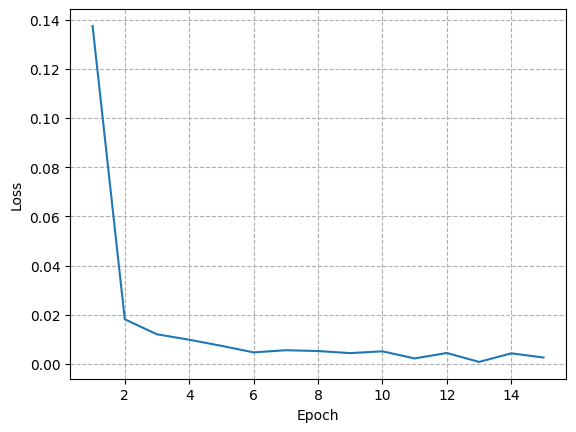

0.0025678723580831843


/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


=========== Train predictions ===========
Accuracy: 1.0000
Confusion Matrix:
[[60498     1     0     0]
 [    0 12352     0     0]
 [    0     0  4501     0]
 [    0     0     0   439]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00     60499
     Class 1       1.00      1.00      1.00     12352
     Class 2       1.00      1.00      1.00      4501
     Class 3       1.00      1.00      1.00       439

    accuracy                           1.00     77791
   macro avg       1.00      1.00      1.00     77791
weighted avg       1.00      1.00      1.00     77791



/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


=========== Test predictions ===========
Accuracy: 0.9999
Confusion Matrix:
[[6722    1    0    0]
 [   0 1373    0    0]
 [   0    0  501    0]
 [   0    0    0   49]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      6723
     Class 1       1.00      1.00      1.00      1373
     Class 2       1.00      1.00      1.00       501
     Class 3       1.00      1.00      1.00        49

    accuracy                           1.00      8646
   macro avg       1.00      1.00      1.00      8646
weighted avg       1.00      1.00      1.00      8646



In [297]:
plt.plot(np.arange(1,NEPOCHS+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(axis = 'both', linestyle = '--')
plt.show()

print(train_losses[-1])

predictions, true_labels = predict(model, train_loader, device)

print("=========== Train predictions ===========")
result_summary(predictions, true_labels)

test_dataset = ImageDataset(df_ts)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(model, test_loader, device)


print("=========== Test predictions ===========")
result_summary(predictions_test, test_labels)

model = BaselineCNN().to(device)
optimizer = optim.Adam

# Improvement : Augmentation

In [ ]:
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform = None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        # Load image and label
        image = self.dataframe.iloc[idx]["img_arr"]
        label = self.dataframe.iloc[idx]["label"]
        
        # Apply transforms
        if self.transform:
            image = image.astype(np.uint8)  # Ensure image is uint8 before transforms
            image = self.transform(image)
        else:
            image_tensor = torch.from_numpy(image)
            if image_tensor.shape[-1] == 3:
                image = image_tensor.permute(2,0,1)
            image = torch.tensor(image, dtype = torch.float32)
        
        # Ensure label is a tensor
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [ ]:
transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.3),               # Horizontally flip with 30% probability
    v2.RandomVerticalFlip(p=0.3),                 # Vertically flip with 30% probability
    v2.GaussianBlur(kernel_size=(3, 3)),          # Blur the images using a 3x3 Gaussian kernel
    v2.RandomRotation(degrees=(-45, 45)),         # Randomly rotate the images between -45 and 45 degrees
    v2.ToTensor(),                                # Convert image to a PyTorch tensor (float32 automatically)
    v2.Normalize(mean=[0.485, 0.456, 0.406],      # Normalize for 3-channel RGB (ImageNet mean)
                 std=[0.229, 0.224, 0.225]),      # Standard deviation for ImageNet
])

train_dataset = ImageDataset(df, transforms) # Needed as we changed the defn of ImageDataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [ ]:
model_aug = BaselineCNN().to(device)
optimizer = optim.AdamW(model_aug.parameters(), lr=learning_rate)
model_aug, train_losses_aug = train_model(model_aug, train_loader, optimizer, num_epochs=30)

In [ ]:
plt.plot(np.arange(1, 30+1), train_losses_aug)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(axis = 'both', linestyle = '--')
plt.show()

print(train_losses_aug[-1])


In [ ]:
train_predictions, train_labels = predict(model_aug, train_loader, device)
test_predictions, test_labels = predict(model_aug, test_loader, device)

result_summary(train_predictions, train_labels)
result_summary(test_predictions, test_labels)

# Improvement : Transfer Learning

In [ ]:
model_tf = models.resnet34(weights='IMAGENET1K_V1')

for param in model_tf.parameters(): # Freeze all but the last layer of the network
    param.requires_grad = False

num_ftrs = model_tf.fc.in_features
model_tf.fc = nn.Linear(num_ftrs, N_CLASSES)
model_tf = model_tf.to(device)



In [ ]:
model_tf.fc = nn.Linear(num_ftrs, N_CLASSES)
model_tf = model_tf.to(device)


optimizer = optim.AdamW(model_tf.fc.parameters(), lr=learning_rate) # todo: Add momentum?
model3, train_losses3 = train_model(model_tf, train_loader, optimizer, num_epochs=NEPOCHStf)

plt.plot(np.arange(1, NEPOCHStf+1), train_losses3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print(train_losses3[-1])


In [ ]:

model3.eval()
train_predictions, train_labels = predict(model3, train_loader, device)
test_predictions, test_labels = predict(model3, test_loader, device)

result_summary(train_predictions, train_labels)
result_summary(test_predictions, test_labels)

# Improvement : ADASYN upsampling

In [ ]:
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import SMOTE


train_dataset = ImageDataset(df_tr)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

images, labels = next(iter(train_loader))
images = images.numpy()  # NumPy 배열로 변환
labels = labels.numpy()

# adasyn = ADASYN(sampling_strategy='minority', n_neighbors=5, random_state=42)
# X_resampled, y_resampled = adasyn.fit_resample(images.reshape(len(images), -1), labels)

# X_resampled = X_resampled.reshape(-1, 3, 128, 128)  # (N, C, H, W)로 변환

# X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
# y_resampled = torch.tensor(y_resampled, dtype=torch.long)

# bal_train_data = torch.utils.data.TensorDataset(X_resampled, y_resampled)
# bal_train_loader = DataLoader(bal_train_data, batch_size=32, shuffle=True)

smote = SMOTE(sampling_strategy='not majority', random_state=42)
X_resampled, y_resampled = smote.fit_resample(images.reshape(len(images), -1), labels)

X_resampled = X_resampled.reshape(-1, 3, 128, 128)  # (N, C, H, W)로 변환

X_resampled = torch.tensor(X_resampled, dtype=torch.float32)
y_resampled = torch.tensor(y_resampled, dtype=torch.long)

bal_train_data = torch.utils.data.TensorDataset(X_resampled, y_resampled)
bal_train_loader = DataLoader(bal_train_data, batch_size=32, shuffle=True)

/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


In [ ]:
unique_labels, counts = torch.unique(torch.tensor([label for _, label in bal_train_data]), return_counts=True)
print(f"Label distribution in bal_train_data: {dict(zip(unique_labels.tolist(), counts.tolist()))}")

unique_labels, counts = torch.unique(torch.tensor([label for _, label in train_dataset]), return_counts=True)
print(f"Label distribution in train_dataset: {dict(zip(unique_labels.tolist(), counts.tolist()))}")



Label distribution in bal_train_data: {0: 1756, 1: 1756, 2: 1756, 3: 1756}


/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


Label distribution in train_dataset: {0: 1756, 1: 1317, 2: 878, 3: 439}


In [ ]:
model = BaselineCNN().to(device)
optimizer = optim.AdamW(model.parameters(), lr = learning_rate)
model_sm, train_losses = train_model(model, bal_train_loader, optimizer)


plt.plot(np.arange(1,NEPOCHS+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(axis = 'both', linestyle = '--')
plt.show()

print(train_losses[-1])

In [ ]:
predictions, true_labels = predict(model, bal_train_loader, device)

print("=========== Train predictions ===========")
result_summary(predictions, true_labels)

test_dataset = ImageDataset(df_ts)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(model, test_loader, device)


print("=========== Test predictions ===========")
result_summary(predictions_test, test_labels)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /Users/ibolam/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:34<00:00, 7.04MB/s] 
100%|██████████| 30/30 [08:28<00:00, 16.94s/it]

Finished Training


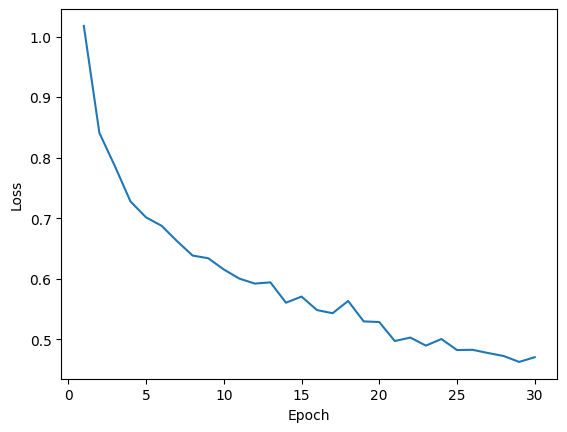

0.4707211785018444


In [ ]:
model_tf = models.resnet152(weights='IMAGENET1K_V1')

for param in model_tf.parameters(): # Freeze all but the last layer of the network
    param.requires_grad = False

num_ftrs = model_tf.fc.in_features
model_tf.fc = nn.Linear(num_ftrs, N_CLASSES)
model_tf = model_tf.to(device)


NEPOCHStf = 30
optimizer = optim.AdamW(model_tf.fc.parameters(), lr=learning_rate) # todo: Add momentum?
bal_model3, bal_train_losses3 = train_model(model_tf, bal_train_loader, optimizer, num_epochs=NEPOCHStf)

plt.plot(np.arange(1, NEPOCHStf+1), bal_train_losses3)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print(bal_train_losses3[-1])


In [169]:
predictions, true_labels = predict(bal_model3, bal_train_loader, device)

print("=========== Train predictions ===========")
result_summary(predictions, true_labels)

test_dataset = ImageDataset(df_ts)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
predictions_test, test_labels = predict(bal_model3, test_loader, device)


print("=========== Test predictions ===========")
result_summary(predictions_test, test_labels)

=========== Train predictions ===========
Accuracy: 0.8818
Confusion Matrix:
[[1574  100   82    0]
 [ 269 1300  186    1]
 [  70   50 1634    2]
 [  11   12   47 1686]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.82      0.90      0.86      1756
     Class 1       0.89      0.74      0.81      1756
     Class 2       0.84      0.93      0.88      1756
     Class 3       1.00      0.96      0.98      1756

    accuracy                           0.88      7024
   macro avg       0.89      0.88      0.88      7024
weighted avg       0.89      0.88      0.88      7024



/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


=========== Test predictions ===========
Accuracy: 0.7163
Confusion Matrix:
[[153  22  19   2]
 [ 37  78  32   0]
 [ 13   9  75   1]
 [  2   0   2  45]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.75      0.78      0.76       196
     Class 1       0.72      0.53      0.61       147
     Class 2       0.59      0.77      0.66        98
     Class 3       0.94      0.92      0.93        49

    accuracy                           0.72       490
   macro avg       0.75      0.75      0.74       490
weighted avg       0.72      0.72      0.71       490



  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)
100%|██████████| 30/30 [05:34<00:00, 11.16s/it]

Finished Training


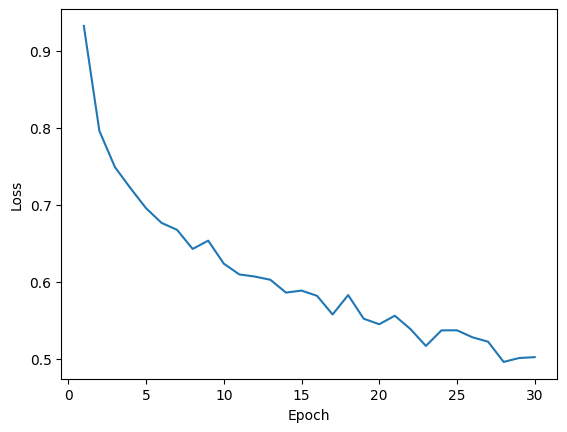

0.5023017018169597
=========== Train predictions ===========
Accuracy: 0.8467
Confusion Matrix:
[[1567  148   41    0]
 [ 207 1049   61    0]
 [  72  101  704    1]
 [  12   15   15  397]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.84      0.89      0.87      1756
     Class 1       0.80      0.80      0.80      1317
     Class 2       0.86      0.80      0.83       878
     Class 3       1.00      0.90      0.95       439

    accuracy                           0.85      4390
   macro avg       0.87      0.85      0.86      4390
weighted avg       0.85      0.85      0.85      4390



/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


=========== Test predictions ===========
Accuracy: 0.7245
Confusion Matrix:
[[156  28  11   1]
 [ 40  91  16   0]
 [ 14  17  66   1]
 [  0   2   5  42]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.74      0.80      0.77       196
     Class 1       0.66      0.62      0.64       147
     Class 2       0.67      0.67      0.67        98
     Class 3       0.95      0.86      0.90        49

    accuracy                           0.72       490
   macro avg       0.76      0.74      0.75       490
weighted avg       0.73      0.72      0.72       490



In [ ]:
model_tf = models.resnet152(weights='IMAGENET1K_V1')

for param in model_tf.parameters(): # Freeze all but the last layer of the network
    param.requires_grad = False

num_ftrs = model_tf.fc.in_features
model_tf.fc = nn.Linear(num_ftrs, N_CLASSES)
model_tf = model_tf.to(device)

train_dataset = ImageDataset(df_tr)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

NEPOCHStf = 30
optimizer = optim.AdamW(model_tf.fc.parameters(), lr=learning_rate) # todo: Add momentum?
model152, train_losses152 = train_model(model_tf, train_loader, optimizer, num_epochs=NEPOCHStf)

plt.plot(np.arange(1, NEPOCHStf+1), train_losses152)
plt.xlabel("Epoch")
plt.ylabel("Loss" )
plt.show()

print(train_losses152[-1])

predictions, true_labels = predict(model152, train_loader, device)
print("=========== Train predictions ===========")
result_summary(predictions, true_labels)


predictions_test, test_labels = predict(model152, test_loader, device)
print("=========== Test predictions ===========")
result_summary(predictions_test, test_labels)

# Improvement : AlexNet vs AlexNet with SMOTE

In [175]:
alexnet = models.alexnet(pretrained=True)

num_ftrs = alexnet.classifier[6].in_features
alexnet.classifier[6] = nn.Linear(num_ftrs, N_CLASSES)
alexnet = alexnet.to(device)

for param in alexnet.parameters():
    param.requires_grad = False  # Freeze

# Training new added layer
for param in alexnet.classifier[6].parameters():
    param.requires_grad = True

  0%|          | 0/30 [00:00<?, ?it/s]/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)
100%|██████████| 30/30 [01:02<00:00,  2.07s/it]

Finished Training


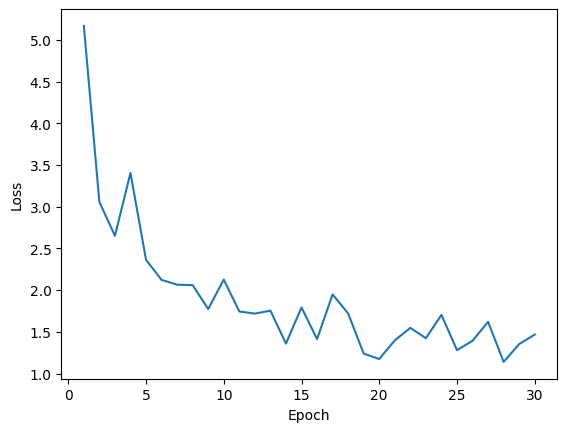

1.4669657497518305
=========== Train predictions ===========
Accuracy: 0.6695
Confusion Matrix:
[[ 885  868    3    0]
 [   8 1309    0    0]
 [  40  518  320    0]
 [   5    9    0  425]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.50      0.66      1756
     Class 1       0.48      0.99      0.65      1317
     Class 2       0.99      0.36      0.53       878
     Class 3       1.00      0.97      0.98       439

    accuracy                           0.67      4390
   macro avg       0.85      0.71      0.71      4390
weighted avg       0.82      0.67      0.66      4390



/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


=========== Test predictions ===========
Accuracy: 0.6102
Confusion Matrix:
[[ 88 103   3   2]
 [  5 141   0   1]
 [  7  66  25   0]
 [  2   2   0  45]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.45      0.59       196
     Class 1       0.45      0.96      0.61       147
     Class 2       0.89      0.26      0.40        98
     Class 3       0.94      0.92      0.93        49

    accuracy                           0.61       490
   macro avg       0.79      0.65      0.63       490
weighted avg       0.75      0.61      0.59       490



In [178]:

train_dataset = ImageDataset(df_tr)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

NEPOCHSa = 30
optimizer = optim.AdamW(alexnet.parameters(), lr=learning_rate) # todo: Add momentum?
alexnet_m, train_losses_ax = train_model(alexnet, train_loader, optimizer, num_epochs=NEPOCHSa)

plt.plot(np.arange(1, NEPOCHSa+1), train_losses_ax)
plt.xlabel("Epoch")
plt.ylabel("Loss" )
plt.show()

print(train_losses_ax[-1])

predictions, true_labels = predict(alexnet_m, train_loader, device)
print("=========== Train predictions ===========")
result_summary(predictions, true_labels)


predictions_test, test_labels = predict(alexnet_m, test_loader, device)
print("=========== Test predictions ===========")
result_summary(predictions_test, test_labels)

100%|██████████| 30/30 [01:15<00:00,  2.51s/it]

Finished Training


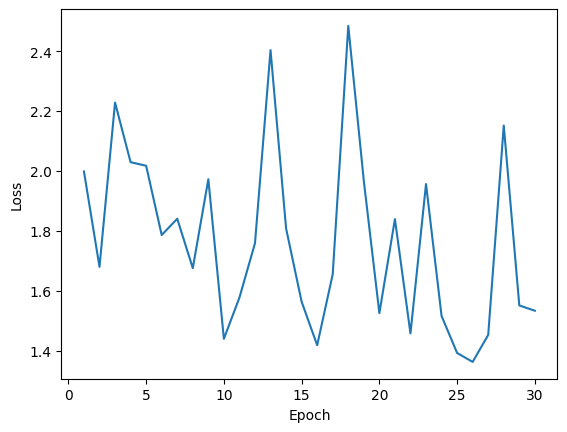

1.5334027725356547
=========== Train predictions ===========
Accuracy: 0.8438
Confusion Matrix:
[[1385  213  158    0]
 [  76 1559  121    0]
 [   5   16 1735    0]
 [  95  174  239 1248]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.89      0.79      0.84      1756
     Class 1       0.79      0.89      0.84      1756
     Class 2       0.77      0.99      0.87      1756
     Class 3       1.00      0.71      0.83      1756

    accuracy                           0.84      7024
   macro avg       0.86      0.84      0.84      7024
weighted avg       0.86      0.84      0.84      7024



/var/folders/fy/1s_xq_2s3bn944gfxpny8t2m0000gn/T/ipykernel_86261/1848906678.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype = torch.float32)


=========== Test predictions ===========
Accuracy: 0.6857
Confusion Matrix:
[[120  50  26   0]
 [ 25 101  21   0]
 [  4  11  83   0]
 [  9   3   5  32]]
Classification Report:
              precision    recall  f1-score   support

     Class 0       0.76      0.61      0.68       196
     Class 1       0.61      0.69      0.65       147
     Class 2       0.61      0.85      0.71        98
     Class 3       1.00      0.65      0.79        49

    accuracy                           0.69       490
   macro avg       0.75      0.70      0.71       490
weighted avg       0.71      0.69      0.69       490



In [179]:

# train_dataset = ImageDataset(df_tr)
# bal_train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

NEPOCHSa = 30
optimizer = optim.AdamW(alexnet.parameters(), lr=learning_rate) # todo: Add momentum?
alexnet_m_b, train_losses_ax_b = train_model(alexnet, bal_train_loader, optimizer, num_epochs=NEPOCHSa)

plt.plot(np.arange(1, NEPOCHSa+1), train_losses_ax_b)
plt.xlabel("Epoch")
plt.ylabel("Loss" )
plt.show()

print(train_losses_ax_b[-1])

predictions, true_labels = predict(alexnet_m_b, bal_train_loader, device)
print("=========== Train predictions ===========")
result_summary(predictions, true_labels)


predictions_test, test_labels = predict(alexnet_m_b, test_loader, device)
print("=========== Test predictions ===========")
result_summary(predictions_test, test_labels)